# What are the most demanded skills for the top 3 most popular data roles?

### Methodology: 
1. Clean-up skill column
2. Calculate skill count based on job_title_short
3. Calculate skill percentage
4. Plot final findings

## Import Libraries and Data

In [5]:
# Importing Libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt  

# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)


## Filter Data for Spain

Filter the data for the market of Spain.

In [6]:
df_Spain = df[df['job_country'] == 'Spain']


## Explode Skills

Converts the `job_skills` column from string representations of lists into actual list objects and then expands these lists so each skill appears in its own row. It then displays the `job_title` and `job_skills` columns, allowing us to analyze the distribution of skills across different data job titles.

In [7]:
df_skills = df_Spain.explode('job_skills')

df_skills[['job_title', 'job_skills']]

,job_title,job_skills
115,Azure Big Data Engineer,scala
115,Azure Big Data Engineer,azure
124,DATA SCIENTIST,sql
124,DATA SCIENTIST,python
124,DATA SCIENTIST,r
...,...,...
785620,Business Intelligence and Data Management Tech...,r
785620,Business Intelligence and Data Management Tech...,java
785620,Business Intelligence and Data Management Tech...,cognos
785620,Business Intelligence and Data Management Tech...,tableau


## Count Skills per Job Title

Groups DataFrame by `job_skills` and `job_title_short`, counting the occurrences of each skill within each job title. Then resets the index of the Series to turn it back into a DataFrame and renames the series holding the count to 'count'. The final DataFrame, `df_skills_count`, shows the frequency of each skill with each job title.



In [8]:
# Group by job_skills and job_title_short and count the number of occurrences
df_skills_count = df_skills.groupby(['job_skills', 'job_title_short']).size()

# Name the count column as count
df_skills_count = df_skills_count.reset_index(name='skill_count')

# Sort the values by skill_count in descending order
df_skills_count.sort_values(by='skill_count', ascending=False, inplace=True)

df_skills_count

,job_skills,job_title_short,skill_count
987,python,Data Engineer,3827
988,python,Data Scientist,3804
1249,sql,Data Engineer,3765
1248,sql,Data Analyst,2595
1250,sql,Data Scientist,2493
...,...,...,...
766,neo4j,Machine Learning Engineer,1
1288,ssrs,Senior Data Analyst,1
1287,ssrs,Machine Learning Engineer,1
762,neo4j,Business Analyst,1


## Create List of Top 3 Roles
#### Focus: Data Analysts, Data Engineers, and Data Scientists
Filter the job titles based on the most popular.

In [9]:
job_titles = df_skills_count['job_title_short'].unique().tolist()

job_titles = sorted(job_titles[:3])

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

## Plot Skill Counts

Creates a stacked horizontal bar chart for the top 5 skills for Top 3 roles, displaying the frequency of each skill.

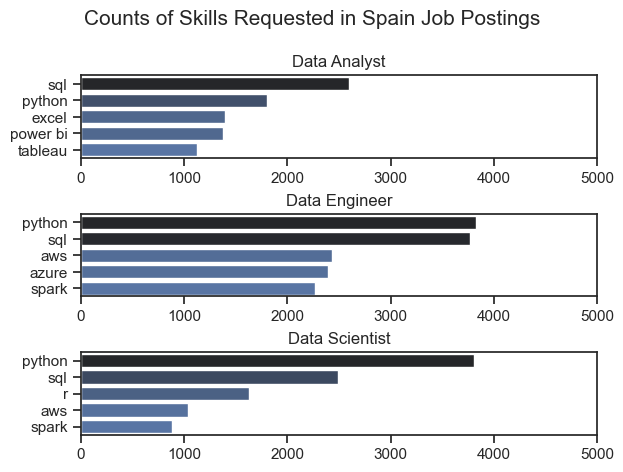

In [13]:
fig, ax = plt.subplots(len(job_titles), 1)

sns.set_theme(style='ticks')

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_count[df_skills_count['job_title_short'] == job_title].head(5)[::-1]
    sns.barplot(data=df_plot, x='skill_count', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].invert_yaxis()
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 5000) # make the scales the same

fig.suptitle('Counts of Skills Requested in Spain Job Postings', fontsize=15)
fig.tight_layout(h_pad=0.5) # fix the overlap
plt.show()

## Convert Counts to Percentages
#### Focus: Counts don't show what portions of jobs are requesting these skills
So we'll convert the counts into percentages which helps us understand how each job title represents relative to the entire dataset.

Before we can calculate the percentages we need the total counts for the jobs posted by job title. Calculate the frequency of each job title using the `value_counts()` method on the `job_title_short` column. Then reset the index to transform the Series into a DataFrame and renames the columns to `job_title_short` and `total`. The DataFrame `df_job_title_count` now holds a list of job titles alongside their total occurrences.

In [15]:
# Use original df to get the count of job titles
df_job_title_count = df_Spain['job_title_short'].value_counts().reset_index(name='jobs_total')

df_job_title_count


,job_title_short,jobs_total
0,Data Engineer,6740
1,Data Scientist,5598
2,Data Analyst,5177
3,Software Engineer,1576
4,Business Analyst,1505
5,Senior Data Engineer,1375
6,Senior Data Scientist,1346
7,Senior Data Analyst,616
8,Machine Learning Engineer,600
9,Cloud Engineer,567


Then we calculate the percentages. First merge `df_skills_count` and `df_job_title_count`, based on the 'job_title_short' column, ensuring each skill count is associated with the total number of job postings for that title. Then calculate the percentage of each skill within its job title by dividing the skill count by the total job postings and multiplying by 100, adding this new data as a 'percentage' column.

In [16]:
df_skills_perc = pd.merge(df_skills_count, df_job_title_count, on='job_title_short', how='left')

df_skills_perc['skill_percent'] = (df_skills_perc['skill_count'] / df_skills_perc['jobs_total']) * 100

df_skills_perc


,job_skills,job_title_short,skill_count,jobs_total,skill_percent
0,python,Data Engineer,3827,6740,56.780415
1,python,Data Scientist,3804,5598,67.952840
2,sql,Data Engineer,3765,6740,55.860534
3,sql,Data Analyst,2595,5177,50.125555
4,sql,Data Scientist,2493,5598,44.533762
...,...,...,...,...,...
1530,neo4j,Machine Learning Engineer,1,600,0.166667
1531,ssrs,Senior Data Analyst,1,616,0.162338
1532,ssrs,Machine Learning Engineer,1,600,0.166667
1533,neo4j,Business Analyst,1,1505,0.066445


## Plot Percentage Count

Filters and sorts a DataFrame to get the top 5 skills percentages for these top 3 roles. After sorting the skills by descending percentage, reverse the order of these top 5 entries to use in a horizontal bar plot, which by default starts plotting from the bottom.



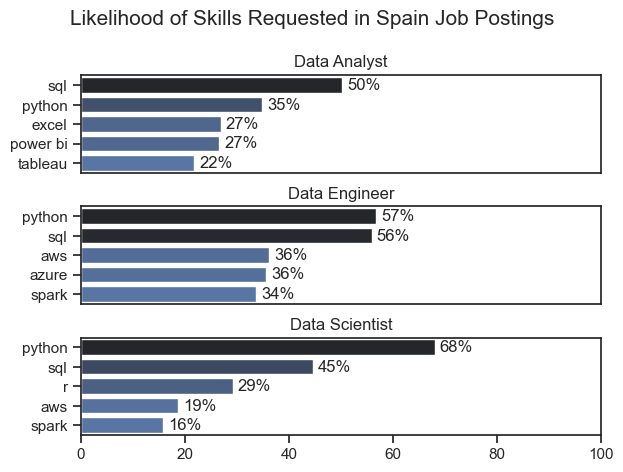

In [18]:
fig, ax = plt.subplots(len(job_titles), 1)


for i, job_title in enumerate(job_titles):
    df_plot = df_skills_perc[df_skills_perc['job_title_short'] == job_title].head(5)
    sns.barplot(data=df_plot, x='skill_percent', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    ax[i].set_title(job_title)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].get_legend().remove()
    ax[i].set_xlim(0, 100)
    # remove the x-axis tick labels for better readability
    if i != len(job_titles) - 1:
        ax[i].set_xticks([])

    # label the percentage on the bars
    for n, v in enumerate(df_plot['skill_percent']):
        ax[i].text(v + 1, n, f'{v:.0f}%', va='center')

fig.suptitle('Likelihood of Skills Requested in Spain Job Postings', fontsize=15)
fig.tight_layout(h_pad=.8)
plt.show()
